In [33]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

# Set a seed for reproducibility
np.random.seed(0)

# Read in the data
data =pd.read_csv('diabetes_prediction_dataset.csv')
print(data.duplicated())
print(data.duplicated().sum())

# dropped dupliccates
data.drop_duplicates(inplace=True)

0        False
1        False
2        False
3        False
4        False
         ...  
99995     True
99996    False
99997    False
99998    False
99999    False
Length: 100000, dtype: bool
3854


In [34]:


sample_df = data.sample(n=30000, random_state=42)


# categorise features into numeric and non numeric
numeric_col = []
non_numeric_col = []
for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
        if data[column].nunique() < 5:
            non_numeric_col.append(column)
        else:
            numeric_col.append(column)
    else:
        non_numeric_col.append(column)


# Label Encoder
class CustomLabelEncoder:
    def __init__(self):
        self.mapping = {}

    def fit(self, data):
        unique_values = set(data)
        self.mapping = {value: index for index, value in enumerate(unique_values)}

    def transform(self, data):
        return [self.mapping[value] for value in data]

# Encoding non-numeric columns
for col in non_numeric_col:
    label_encoder = CustomLabelEncoder()
    label_encoder.fit(sample_df[col])
    sample_df[col] = label_encoder.transform(sample_df[col])






### Synthetic Minority Oversampling Technique:

The synthetic minority oversampling technique (SMOTE) was used to adjust the imbalance in the data set.

SMOTE (Synthetic Minority Over-sampling Technique) is a popular technique used to address class imbalance in machine learning datasets. Class imbalance occurs when one class in the target variable has significantly fewer instances than another class. This imbalance can lead to biased models that perform poorly on the minority class.

SMOTE works by generating synthetic samples for the minority class. It does this by interpolating between existing minority class instances, creating synthetic examples along the line segments connecting some or all of the k minority class nearest neighbors. The term "nearest neighbors" is usually defined in a feature space.

Here's a high-level overview of the SMOTE process:

- Identify Minority Class Instances: SMOTE focuses on the minority class, which is the class with fewer instances.
- Select a Minority Class Instance: Randomly choose an instance from the minority class.
- Find k Nearest Neighbors: Identify the k nearest neighbors for the selected instance. The distance metric used is typically Euclidean distance in the feature space.
- Generate Synthetic Instances: For each neighbor, create a synthetic instance along the line segment between the chosen instance and that neighbor. The number of synthetic instances created depends on the sampling_strategy parameter.
- Repeat: Repeat steps 2-4 until the desired balance between classes is achieved.

By generating synthetic instances, SMOTE helps to balance the class distribution in the training dataset, which can lead to better model performance, especially for classifiers that are sensitive to class imbalance.


In [35]:
# Resample using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled, y_resampled = smote.fit_resample(sample_df.drop('diabetes', axis=1), sample_df['diabetes'])

# Create a DataFrame from the resampled data
sample_df_resampled = pd.DataFrame(x_resampled, columns=sample_df.drop('diabetes', axis=1).columns)
sample_df_resampled['diabetes'] = y_resampled


In [36]:

# Splitting into train, validation and test data
def custom_train_validation_test_split(x, y, test_size=0.2, validation_size=0.2, random_state=None):
    np.random.seed(random_state)
    indices = np.arange(len(x))
    np.random.shuffle(indices)

    test_size = int(test_size * len(x))
    validation_size = int(validation_size * len(x))

    test_indices = indices[:test_size]
    validation_indices = indices[test_size:(test_size + validation_size)]
    train_indices = indices[(test_size + validation_size):]

    x_train, x_val, x_test = x.iloc[train_indices], x.iloc[validation_indices], x.iloc[test_indices]
    y_train, y_val, y_test = y.iloc[train_indices], y.iloc[validation_indices], y.iloc[test_indices]

    return x_train, x_val, x_test, y_train, y_val, y_test


# Use the resampled data for splitting
X_train, X_valid, X_test, y_train, y_valid, y_test = custom_train_validation_test_split(
    sample_df_resampled.drop('diabetes', axis=1),
    sample_df_resampled['diabetes'],
    test_size=0.2,
    validation_size=0.2,
    random_state=42
)


In [37]:

# Standardize the features
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std

# class-specific means for projection
mean_class_0 = X_train[y_train == 0].mean(axis=0)
mean_class_1 = X_train[y_train == 1].mean(axis=0)

#  scatter matrix
scatter_class_0 = np.cov(X_train[y_train == 0], rowvar=False)
scatter_class_1 = np.cov(X_train[y_train == 1], rowvar=False)

# optimal projection direction
S_W = scatter_class_0 + scatter_class_1
w_optimal = np.linalg.inv(S_W).dot(mean_class_1 - mean_class_0)
print(w_optimal)

# Project the validation data
X_valid_projected = np.matmul(X_valid, w_optimal)
# print(X_valid_projected)

# Classify each validation sample
y_pred = np.where(X_valid_projected >= 0, 1, 0)


# Compute accuracy on training data
accuracy_train = np.mean(y_train == (X_train.dot(w_optimal) >= 0))


accuracy_train

# without SMOTE
# 0.6087222222222223

[-0.19407554  0.6447062  -0.07827183 -0.07310832 -0.08791388  0.35596393
  1.02174471  0.74980321]


0.8965527760829775

In [42]:

# accuracy, precision, recall, and F-measure on validation data
def confusion_matrix(y_valid, y_pred):
    true_positives = np.sum((y_valid == 1) & (y_pred == 1))
    false_positives = np.sum((y_valid == 0) & (y_pred == 1))
    false_negatives = np.sum((y_valid == 1) & (y_pred == 0))
    true_negatives = np.sum((y_valid == 0) & (y_pred == 0))

    return np.array([[true_negatives, false_positives],
                     [false_negatives, true_positives]])

# Assuming y_valid and y_pred are the validation labels and predictions, respectively
conf_matrix_valid = confusion_matrix(y_valid, y_pred)

# Extracting values from the confusion matrix
true_negatives, false_positives, false_negatives, true_positives = conf_matrix_valid.flatten()

# Calculating accuracy, precision, recall, and F-measure
accuracy_valid = (true_positives + true_negatives) / len(y_valid)
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Printing results
print("Training Accuracy:", accuracy_train)
print("Validation Accuracy:", accuracy_valid)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f_measure)
print("Confusion Matrix:")
print(conf_matrix_valid)



## without SMOTE
# Training Accuracy: 0.6087222222222223
# Validation Accuracy: 0.607
# Precision: 0.17737430167597765
# Recall: 0.996078431372549
# F-measure: 0.3011262596324837

Training Accuracy: 0.8965527760829775
Validation Accuracy: 0.8944719018854109
Precision: 0.8890508289305884
Recall: 0.8997050147492626
F-measure: 0.8943461926143133
Confusion Matrix:
[[4893  609]
 [ 544 4880]]


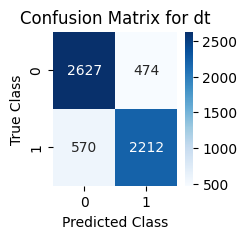

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3101
           1       0.82      0.80      0.81      2782

    accuracy                           0.82      5883
   macro avg       0.82      0.82      0.82      5883
weighted avg       0.82      0.82      0.82      5883



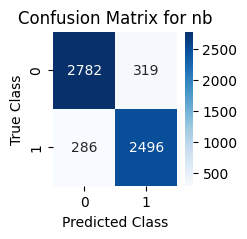

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      3101
           1       0.89      0.90      0.89      2782

    accuracy                           0.90      5883
   macro avg       0.90      0.90      0.90      5883
weighted avg       0.90      0.90      0.90      5883



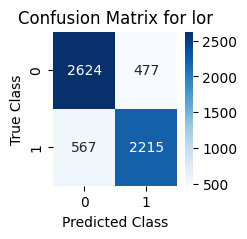

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3101
           1       0.82      0.80      0.81      2782

    accuracy                           0.82      5883
   macro avg       0.82      0.82      0.82      5883
weighted avg       0.82      0.82      0.82      5883



In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
## naive bayes 
def train_naive_bayes(X_train, y_train):
    class_priors = pd.Series(y_train).value_counts(normalize=True).to_dict()

    cols = X_train.columns.tolist()
    naive_probs = {}
    for class_label, class_data in pd.concat([X_train, y_train], axis=1).groupby(y_train.name):
        class_probs = {}
        for feature in cols:
            feature_probs = class_data[feature].value_counts(normalize=True).to_dict()
            class_probs[feature] = feature_probs
        naive_probs[class_label] = class_probs

    return class_priors, naive_probs

def naive_bayes_classifier(sample, class_priors, naive_probs):
    class_scores = {}
    for class_label, class_prob in class_priors.items():
        log_prob = np.log(class_prob)
        for feature, value in sample.items():
            if feature in naive_probs[class_label]:
                log_prob += np.log(naive_probs[class_label][feature].get(value, 1e-10))
        class_scores[class_label] = log_prob
    return max(class_scores, key=class_scores.get)

def predict_naive_bayes(X_train, y_train, X_valid):
    class_priors, naive_probs = train_naive_bayes(X_train, y_train)
    predictions = X_valid.apply(lambda x: naive_bayes_classifier(x, class_priors, naive_probs), axis=1)
    return predictions


## Decision tree
def myDT(Xtrain, Ytrain, Xvalid):
    class DecisionTree:
        def __init__(self):
            self.tree = None

        def fit(self, X, Y):
            self.tree = self._build_tree(X, Y)

        def predict(self, X):
            predictions = []
            for sample in X:
                predictions.append(self._predict_sample(sample, self.tree))
            return np.array(predictions)

        def _entropy(self, Y):
            classes, counts = np.unique(Y, return_counts=True)
            probabilities = counts / len(Y)
            entropy = -np.sum(probabilities * np.log2(probabilities))
            return entropy

        def _information_gain(self, X, Y, feature_index):
            unique_values = np.unique(X[:, feature_index])
            total_entropy = self._entropy(Y)

            weighted_entropy = 0
            for value in unique_values:
                subset_indices = X[:, feature_index] == value
                subset_Y = Y[subset_indices]
                weighted_entropy += len(subset_Y) / len(Y) * self._entropy(subset_Y)

            information_gain = total_entropy - weighted_entropy
            return information_gain

        def _build_tree(self, X, Y, depth=0):
            num_samples, num_features = X.shape
            unique_classes = np.unique(Y)

            # Base cases
            if len(unique_classes) == 1:
                # If all samples belong to the same class, return a leaf node
                return {'class': unique_classes[0]}
            # Limit the depth for simplicity
            if depth == 1000:  
                # If maximum depth is reached, return a leaf node with the majority class
                majority_class = np.argmax(np.bincount(Y))
                return {'class': majority_class}

            # Find the best split
            best_feature = None
            best_information_gain = -1
            for feature_index in range(num_features):
                information_gain = self._information_gain(X, Y, feature_index)
                if information_gain > best_information_gain:
                    best_feature = feature_index
                    best_information_gain = information_gain

            if best_information_gain == 0:
                # If no information gain, return a leaf node with the majority class
                majority_class = np.argmax(np.bincount(Y))
                return {'class': majority_class}

            # Split the data based on the best feature
            unique_values = np.unique(X[:, best_feature])
            node = {'feature': best_feature, 'children': {}}
            for value in unique_values:
                subset_indices = X[:, best_feature] == value
                subset_X = X[subset_indices]
                subset_Y = Y[subset_indices]
                node['children'][value] = self._build_tree(subset_X, subset_Y, depth + 1)

            return node

        def _predict_sample(self, sample, tree):
            if 'class' in tree:
                # If leaf node, return the class
                return tree['class']
            else:
                # Recursively traverse the tree
                feature_value = sample[tree['feature']]
                if feature_value not in tree['children']:
                    # If the feature value is not in the training data, return majority class
                    return np.argmax(np.bincount(Y))
                else:
                    return self._predict_sample(sample, tree['children'][feature_value])

    dt = DecisionTree()
    dt.fit(Xtrain, Ytrain)
    predictions = dt.predict(Xvalid)
    return predictions


### Logistics regression
import numpy as np
mean_log_loss_trn=[]
mean_log_loss_val = []
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=10000, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.verbose = verbose
        self.weights = None
        self.bias = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, Y, x_val,y_val):
        global mean_log_loss_trn,mean_log_loss_val
        num_samples, num_features = X.shape
        
        # Initialize weights and bias
        self.weights = np.zeros(num_features)
        self.weights_val = np.zeros(x_val.shape[1])
        self.bias = 0
        self.bias_val = 0
        # Gradient descent
        for i in range(self.num_iterations):
            # print(i)
            # Compute predicted values
            linear_model = np.dot(X, self.weights) + self.bias
            linear_model_x_val = np.dot(x_val, self.weights_val) + self.bias_val
            predictions_x_train = self.sigmoid(linear_model)
            predictions_x_val = self.sigmoid(linear_model_x_val)
            
            # Compute gradients
            dw_tn = (1 / num_samples) * np.dot(X.T, (predictions_x_train - Y))
            dw_val = (1 / num_samples) * np.dot(x_val.T, (predictions_x_val - y_val))

            db_tn = (1 / num_samples) * np.sum(predictions_x_train - Y)
            db_val = (1 / num_samples) * np.sum(predictions_x_val - y_val)
            
            # Update weights and bias
            self.weights_val -= self.learning_rate * dw_val
            self.bias_val -= self.learning_rate * db_val
            self.weights -= self.learning_rate * dw_tn
            self.bias -= self.learning_rate * db_tn
            mean_log_loss_val.append((-1 / num_samples) * np.sum(y_val * np.log(predictions_x_val) + (1 - y_val) * np.log(1 - predictions_x_val)))
            mean_log_loss_trn.append((-1 / num_samples) * np.sum(Y * np.log(predictions_x_train) + (1 - Y) * np.log(1 - predictions_x_train)))

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        predictions = self.sigmoid(linear_model)
        return np.round(predictions)
    
### knn 
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def knn_predict(X_train, Y_train, X_valid, k=2, n_jobs=-1):
    predictions = []

    def process_row(valid_row, X_train, Y_train, k):
        distances = []
        for train_index, train_row in X_train.iterrows():
            dist = euclidean_distance(valid_row, train_row)
            distances.append((train_index, dist))

        distances.sort(key=lambda x: x[1])
        neighbors = distances[:k]
        neighbor_labels = [Y_train.loc[i[0]] for i in neighbors]

        # Perform a simple majority vote
        prediction = max(set(neighbor_labels), key=neighbor_labels.count)
        return prediction

    # Use joblib for parallel processing
    predictions = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(valid_row, X_train, Y_train, k)
        for _, valid_row in X_valid.iterrows()
    )

    return predictions


## evaluations 
def evaluate_performance(Ytrue, Ypred):
    accuracy = (Ypred == Ytrue).mean()

    unique_classes = sorted(Ytrue.unique())
    conf_matrix = np.zeros((len(unique_classes), len(unique_classes)))

    for i, true_class in enumerate(unique_classes):
        for j, predicted_class in enumerate(unique_classes):
            conf_matrix[i, j] = np.sum((Ytrue == true_class) & (Ypred == predicted_class))

    return accuracy, conf_matrix

# Step 1: Reading in the data
df = pd.read_csv('diabetes_prediction_dataset.csv')
df = pd.get_dummies(df, columns=["gender", "smoking_history"])

# Selecting data for diabetic and non-diabetic patients
diabetic_data = df[df['diabetes'] == 1]
non_diabetic_data = df[df['diabetes'] == 0].sample(frac=0.1)

# Concatenate the datasets to create the final dataset
data = pd.concat([diabetic_data, non_diabetic_data])

# Step 2: Shuffling the observations
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Columns to use for training and validation
cols = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
        'blood_glucose_level', 'gender_Female', 'gender_Male',
        'gender_Other', 
        # 'smoking_history_No Info', 'smoking_history_current',
        # 'smoking_history_ever', 'smoking_history_former',
        # 'smoking_history_never', 'smoking_history_not current'
        ]

# Splitting data into training and validation sets
np.random.seed(0)
train_size = int(np.ceil(2 / 3 * len(data)))
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:]

X_train = train_data[cols]
Y_train = train_data['diabetes']
X_valid = val_data[cols]
Y_valid = val_data['diabetes'].astype(int)

# Pre-processing data
means = X_train.mean()
X_train_binary = (X_train > means).astype(int)
X_valid_binary = (X_valid > means).astype(int)


## dtree
dt_pred = myDT(X_train_binary.values, Y_train.astype(int).values, X_valid_binary.values)

## naive bayes
nb_pred = predict_naive_bayes(X_train, Y_train, X_valid)



##knn
# knn_pred = knn_predict(X_train, Y_train, X_valid, k=2)


### logistics reg
model = LogisticRegression(learning_rate=0.01, num_iterations=9000, verbose=True)
model.fit(X_train_binary, Y_train.astype(int), X_valid_binary,Y_valid)
lor_pred = model.predict(X_valid_binary)


unique_classes = sorted(val_data['diabetes'].unique())
conf_matrix = np.zeros((len(unique_classes), len(unique_classes)))
for model_pred,model_name in zip([dt_pred,nb_pred,lor_pred],['Decision Tree','Naive Bayes','Logistic Reg']):
    for i, true_class in enumerate(unique_classes):
        for j, predicted_class in enumerate(unique_classes):
            conf_matrix[i, j] = np.sum((val_data['diabetes'] == true_class) & (model_pred == predicted_class))
    accuracy, confusion_matrix = evaluate_performance(val_data['diabetes'] , model_pred)

    # Plotting Confusion Matrix
    plt.figure(figsize=(2, 2))
    sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    print(classification_report(val_data['diabetes'], model_pred))


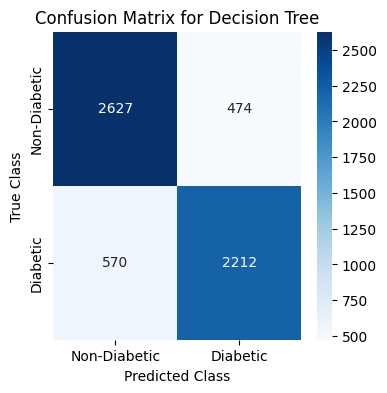

Accuracy for Decision Tree: 0.8225
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3101
           1       0.82      0.80      0.81      2782

    accuracy                           0.82      5883
   macro avg       0.82      0.82      0.82      5883
weighted avg       0.82      0.82      0.82      5883



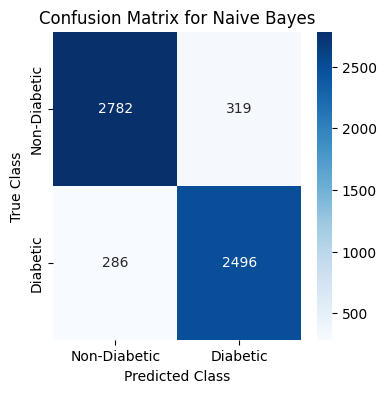

Accuracy for Naive Bayes: 0.8972
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      3101
           1       0.89      0.90      0.89      2782

    accuracy                           0.90      5883
   macro avg       0.90      0.90      0.90      5883
weighted avg       0.90      0.90      0.90      5883



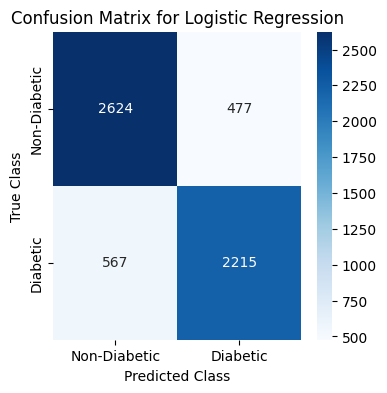

Accuracy for Logistic Regression: 0.8225
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3101
           1       0.82      0.80      0.81      2782

    accuracy                           0.82      5883
   macro avg       0.82      0.82      0.82      5883
weighted avg       0.82      0.82      0.82      5883



In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


def train_naive_bayes(X_train, y_train):
    class_priors = pd.Series(y_train).value_counts(normalize=True).to_dict()

    cols = X_train.columns.tolist()
    naive_probs = {}
    for class_label, class_data in pd.concat([X_train, y_train], axis=1).groupby(
        y_train.name
    ):
        class_probs = {}
        for feature in cols:
            feature_probs = class_data[feature].value_counts(normalize=True).to_dict()
            class_probs[feature] = feature_probs
        naive_probs[class_label] = class_probs

    return class_priors, naive_probs


def naive_bayes_classifier(sample, class_priors, naive_probs):
    class_scores = {}
    for class_label, class_prob in class_priors.items():
        log_prob = np.log(class_prob)
        for feature, value in sample.items():
            if feature in naive_probs[class_label]:
                log_prob += np.log(naive_probs[class_label][feature].get(value, 1e-10))
        class_scores[class_label] = log_prob
    return max(class_scores, key=class_scores.get)


def predict_naive_bayes(X_train, y_train, X_valid):
    class_priors, naive_probs = train_naive_bayes(X_train, y_train)
    predictions = X_valid.apply(
        lambda x: naive_bayes_classifier(x, class_priors, naive_probs), axis=1
    )
    return predictions


## Decision tree
def myDT(Xtrain, Ytrain, Xvalid):
    class DecisionTree:
        def __init__(self):
            self.tree = None

        def fit(self, X, Y):
            self.tree = self._build_tree(X, Y)

        def predict(self, X):
            predictions = []
            for sample in X:
                predictions.append(self._predict_sample(sample, self.tree))
            return np.array(predictions)

        def _entropy(self, Y):
            classes, counts = np.unique(Y, return_counts=True)
            probabilities = counts / len(Y)
            entropy = -np.sum(probabilities * np.log2(probabilities))
            return entropy

        def _information_gain(self, X, Y, feature_index):
            unique_values = np.unique(X[:, feature_index])
            total_entropy = self._entropy(Y)

            weighted_entropy = 0
            for value in unique_values:
                subset_indices = X[:, feature_index] == value
                subset_Y = Y[subset_indices]
                weighted_entropy += len(subset_Y) / len(Y) * self._entropy(subset_Y)

            information_gain = total_entropy - weighted_entropy
            return information_gain

        def _build_tree(self, X, Y, depth=0):
            num_samples, num_features = X.shape
            unique_classes = np.unique(Y)

            # Base cases
            if len(unique_classes) == 1:
                # If all samples belong to the same class, return a leaf node
                return {"class": unique_classes[0]}
            # Limit the depth for simplicity
            if depth == 1000:
                # If maximum depth is reached, return a leaf node with the majority class
                majority_class = np.argmax(np.bincount(Y))
                return {"class": majority_class}

            # Find the best split
            best_feature = None
            best_information_gain = -1
            for feature_index in range(num_features):
                information_gain = self._information_gain(X, Y, feature_index)
                if information_gain > best_information_gain:
                    best_feature = feature_index
                    best_information_gain = information_gain

            if best_information_gain == 0:
                # If no information gain, return a leaf node with the majority class
                majority_class = np.argmax(np.bincount(Y))
                return {"class": majority_class}

            # Split the data based on the best feature
            unique_values = np.unique(X[:, best_feature])
            node = {"feature": best_feature, "children": {}}
            for value in unique_values:
                subset_indices = X[:, best_feature] == value
                subset_X = X[subset_indices]
                subset_Y = Y[subset_indices]
                node["children"][value] = self._build_tree(
                    subset_X, subset_Y, depth + 1
                )

            return node

        def _predict_sample(self, sample, tree):
            if "class" in tree:
                # If leaf node, return the class
                return tree["class"]
            else:
                # Recursively traverse the tree
                feature_value = sample[tree["feature"]]
                if feature_value not in tree["children"]:
                    # If the feature value is not in the training data, return majority class
                    return np.argmax(np.bincount(Y))
                else:
                    return self._predict_sample(sample, tree["children"][feature_value])

    dt = DecisionTree()
    dt.fit(Xtrain, Ytrain)
    predictions = dt.predict(Xvalid)
    return predictions


### Logistics regression
import numpy as np

mean_log_loss_trn = []
mean_log_loss_val = []


class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=10000, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.verbose = verbose
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, Y, x_val, y_val):
        global mean_log_loss_trn, mean_log_loss_val
        num_samples, num_features = X.shape

        # Initialize weights and bias
        self.weights = np.zeros(num_features)
        self.weights_val = np.zeros(x_val.shape[1])
        self.bias = 0
        self.bias_val = 0
        # Gradient descent
        for i in range(self.num_iterations):
            # print(i)
            # Compute predicted values
            linear_model = np.dot(X, self.weights) + self.bias
            linear_model_x_val = np.dot(x_val, self.weights_val) + self.bias_val
            predictions_x_train = self.sigmoid(linear_model)
            predictions_x_val = self.sigmoid(linear_model_x_val)

            # Compute gradients
            dw_tn = (1 / num_samples) * np.dot(X.T, (predictions_x_train - Y))
            dw_val = (1 / num_samples) * np.dot(x_val.T, (predictions_x_val - y_val))

            db_tn = (1 / num_samples) * np.sum(predictions_x_train - Y)
            db_val = (1 / num_samples) * np.sum(predictions_x_val - y_val)

            # Update weights and bias
            self.weights_val -= self.learning_rate * dw_val
            self.bias_val -= self.learning_rate * db_val
            self.weights -= self.learning_rate * dw_tn
            self.bias -= self.learning_rate * db_tn
            mean_log_loss_val.append(
                (-1 / num_samples)
                * np.sum(
                    y_val * np.log(predictions_x_val)
                    + (1 - y_val) * np.log(1 - predictions_x_val)
                )
            )
            mean_log_loss_trn.append(
                (-1 / num_samples)
                * np.sum(
                    Y * np.log(predictions_x_train)
                    + (1 - Y) * np.log(1 - predictions_x_train)
                )
            )

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        predictions = self.sigmoid(linear_model)
        return np.round(predictions)


### knn
import pandas as pd
import numpy as np
from joblib import Parallel, delayed


def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))


def knn_predict(X_train, Y_train, X_valid, k=2, n_jobs=-1):
    predictions = []

    def process_row(valid_row, X_train, Y_train, k):
        distances = []
        for train_index, train_row in X_train.iterrows():
            dist = euclidean_distance(valid_row, train_row)
            distances.append((train_index, dist))

        distances.sort(key=lambda x: x[1])
        neighbors = distances[:k]
        neighbor_labels = [Y_train.loc[i[0]] for i in neighbors]

        # Perform a simple majority vote
        prediction = max(set(neighbor_labels), key=neighbor_labels.count)
        return prediction

    # Use joblib for parallel processing
    predictions = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(valid_row, X_train, Y_train, k)
        for _, valid_row in X_valid.iterrows()
    )

    return predictions


## evaluations
def evaluate_performance(Ytrue, Ypred):
    accuracy = (Ypred == Ytrue).mean()

    unique_classes = sorted(Ytrue.unique())
    conf_matrix = np.zeros((len(unique_classes), len(unique_classes)))

    for i, true_class in enumerate(unique_classes):
        for j, predicted_class in enumerate(unique_classes):
            conf_matrix[i, j] = np.sum(
                (Ytrue == true_class) & (Ypred == predicted_class)
            )

    return accuracy, conf_matrix


# Step 1: Reading in the data
df = pd.read_csv("diabetes_prediction_dataset.csv")
df = pd.get_dummies(df, columns=["gender", "smoking_history"])

# Selecting data for diabetic and non-diabetic patients
diabetic_data = df[df["diabetes"] == 1]
non_diabetic_data = df[df["diabetes"] == 0].sample(frac=0.1)
data = pd.concat([diabetic_data, non_diabetic_data])

# Step 2: Shuffling the observations
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Columns to use for training and validation
cols = [
    "age",
    "hypertension",
    "heart_disease",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level",
    "gender_Female",
    "gender_Male",
    "gender_Other",
]

# Splitting data into training and validation sets
np.random.seed(0)
train_size = int(np.ceil(2 / 3 * len(data)))
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:]

X_train = train_data[cols]
Y_train = train_data["diabetes"]
X_valid = val_data[cols]
Y_valid = val_data["diabetes"].astype(int)

# Pre-processing data
means = X_train.mean()
X_train_binary = (X_train > means).astype(int)
X_valid_binary = (X_valid > means).astype(int)

# Machine Learning Models

## Decision Tree
dt_pred = myDT(X_train_binary.values, Y_train.astype(int).values, X_valid_binary.values)

## Naive Bayes
nb_pred = predict_naive_bayes(X_train, Y_train, X_valid)

## Logistic Regression
model = LogisticRegression(learning_rate=0.01, num_iterations=9000, verbose=True)
model.fit(X_train_binary, Y_train.astype(int), X_valid_binary, Y_valid)
lor_pred = model.predict(X_valid_binary)

### KNN
knn_pred = knn_predict(X_train, Y_train, X_valid, k=2)

# Evaluation and Visualization

model_preds = [dt_pred, nb_pred, lor_pred]
model_names = ["Decision Tree", "Naive Bayes", "Logistic Regression"]

for model_pred, model_name in zip(model_preds, model_names):
    conf_matrix = confusion_matrix(Y_valid, model_pred)
    accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

    # Plotting Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt=".0f",
        cmap="Blues",
        xticklabels=["Non-Diabetic", "Diabetic"],
        yticklabels=["Non-Diabetic", "Diabetic"],
    )
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    print(f"Accuracy for {model_name}: {accuracy:.4f}")
    print(classification_report(Y_valid, model_pred))
    print("--------------------------------------------------------")

In [15]:
pred = knn_predict(X_train, Y_train, X_valid) 

Accuracy: 0.8312085670576237


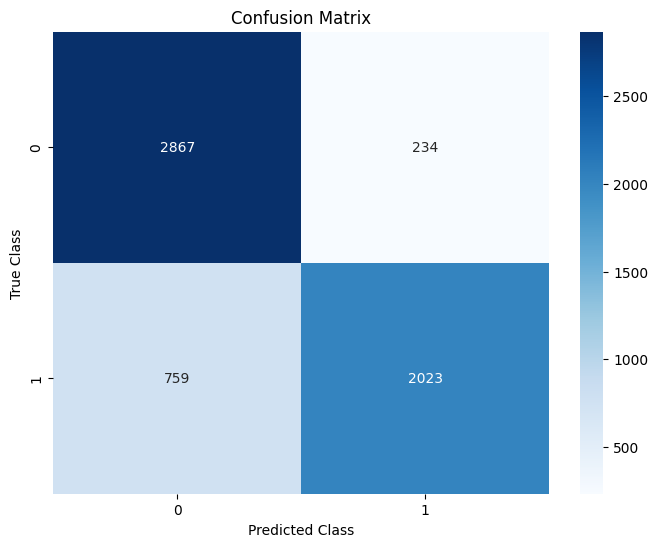

In [20]:
# Evaluating accuracy and confusion matrix
accuracy, confusion_matrix = evaluate_performance(Y_valid, pred)
print(f'Accuracy: {accuracy}')

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()